# Pokemon コンペティション

### コンペ概要
ポケモンの能力値等を示すいくつかの変数からポケモンの対戦結果を予測するコンペです.
(期間: ~ 5/28 23:59)

### 配布データ
- train.csv: 訓練用のデータです. `pokemon.csv`のidに対応しています．
  - First_pokemon: ポケモンのid
  - Second_pokemon: ポケモンのid
  - Winner: 対戦で勝利したポケモンのid
- test.csv: このファイルのデータに対して勝利するポケモンを予測してもらいます.
- pokemon.csv: ポケモンの能力値のデータです． `#` カラムがidを表しています．

### 提出物

test.csvのデータに対して, `First_pokemon` が勝利する確率 `probability` を予測し, 以下のような形式のcsvファイル```submission.csv```を作成してiLect上で提出してください. ただし, 予測値は0以上1以下の値を出力してください.

```
id,probability
0,0.5
1,0.5
...

```

注意点
- 1行目はヘッダーです. 必ず```id,probability```と書いてください.
- 2行目以降は, test.csvのデータの順番と対応させる形でidと予測値を各行に1つずつ出力してください. (idは昇順に並んでいます)
- sample_submission.csvが提出形式のサンプルになので, こちらも参照してみてください.
- **提出前にフォーマットが合っているか必ず確認してください**

### 評価指標
LogLossで評価します.
データ数: N, 真の値: $y$, 予測値: $\hat{y}$ とすると, LogLossは

$$
LogLoss = -\frac{1}{N} \sum_{i=1}^{N}y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i})
$$

で定義されます.

### 賞金
```
1位: 15,000円
2位: 10,000円
3位: 5,000円
```


流れ説明（消しちゃったりしたので）

1. 色々(random forest, xgboost, dnnを深さや活性化関数変えるなど3種)やってみてrandom forestとdnnの平均がベストと判明
2. 本番データの正規化は本番データだけで正規化した方がいいこと判明
3. 本当に平均でいいのかなどを、random forestや線形回帰で確かめるも平均よりいいものは作れないこと判明
4. random forestとdnnで説明変数を変えると精度向上

# データの観察

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
pokemon = pd.read_csv('pokemon.csv')

In [3]:
data.head()

,id,First_pokemon,Second_pokemon,Winner
0,0,88,85,85
1,1,466,408,466
2,2,715,120,715
3,3,467,377,467
4,4,416,206,206


In [4]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [5]:
data.shape

(40000, 4)

In [6]:
wins = np.zeros(len(pokemon))
loses = np.zeros(len(pokemon))
for d in data.values:
    if d[1] == d[3]:
        loses[d[2]-1] += 1
    else:
        loses[d[1]-1] += 1
    wins[d[3]-1] += 1

In [7]:
matches = wins + loses

In [8]:
win_rate = wins / matches

/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [9]:
win_rate[np.isnan(win_rate)] = 0

In [10]:
win_rate

array([0.28440367, 0.41747573, 0.65789474, 0.54716981, 0.48913043,
       0.55789474, 0.86538462, 0.84070796, 0.85436893, 0.17021277,
       0.36734694, 0.        , 0.56666667, 0.14583333, 0.11538462,
       0.62626263, 0.20731707, 0.13333333, 0.63207547, 0.97802198,
       0.35643564, 0.54639175, 0.87619048, 0.94949495, 0.5       ,
       0.72727273, 0.45454545, 0.81443299, 0.39      , 0.56074766,
       0.65714286, 0.87777778, 0.        , 0.53333333, 0.17894737,
       0.39655172, 0.5483871 , 0.25225225, 0.42574257, 0.57522124,
       0.15384615, 0.42105263, 0.38834951, 0.81081081, 0.11428571,
       0.        , 0.34513274, 0.75471698, 0.06542056, 0.22321429,
       0.34020619, 0.1       , 0.20325203, 0.20833333, 0.68103448,
       0.57142857, 0.82828283, 0.6446281 , 0.84946237, 0.3364486 ,
       0.69892473, 0.5       , 0.77906977, 0.43678161, 0.81521739,
       0.        , 0.70873786, 0.47524752, 0.29032258, 0.62037037,
       0.75438596, 0.79347826, 0.13114754, 0.22916667, 0.40659

In [11]:
non_match_pokemon_idx = np.where(matches==0)[0]
non_match_pokemon_idx

array([ 11,  32,  45,  65,  77,  89, 143, 182, 235, 321, 418, 478, 555,
       617, 654, 781])

In [12]:
test = pd.read_csv('test.csv')

In [13]:
test.head()

,id,First_pokemon,Second_pokemon
0,0,85,602
1,1,536,155
2,2,189,644
3,3,526,166
4,4,690,772


In [14]:
f_p = test.loc[:,['First_pokemon']].values
s_p = test.loc[:,['Second_pokemon']].values

In [15]:
for p in s_p:
    if p in non_match_pokemon_idx+1:
        print(p)

In [16]:
for p in f_p:
    if p in non_match_pokemon_idx+1:
        print(p)

trainデータに載ってないポケモンはtestデータにも登場しない

In [17]:
win_rate_sorted = win_rate.copy()
win_rate_sorted.sort()
win_rate_sorted

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00970874, 0.01869159, 0.03921569,
       0.04081633, 0.04395604, 0.04545455, 0.04854369, 0.05050505,
       0.05263158, 0.05263158, 0.05882353, 0.06060606, 0.06382979,
       0.06542056, 0.06666667, 0.06730769, 0.07070707, 0.07317073,
       0.07368421, 0.07894737, 0.08080808, 0.08080808, 0.08256881,
       0.08333333, 0.08653846, 0.08823529, 0.0952381 , 0.09734513,
       0.1       , 0.10091743, 0.10309278, 0.10377358, 0.10483871,
       0.10638298, 0.10714286, 0.11      , 0.11009174, 0.11111111,
       0.11340206, 0.11428571, 0.11538462, 0.11650485, 0.11650485,
       0.11711712, 0.12244898, 0.125     , 0.125     , 0.12745098,
       0.13114754, 0.13333333, 0.13414634, 0.13432836, 0.13483146,
       0.13978495, 0.14035088, 0.14049587, 0.14102564, 0.14150

In [18]:
len(matches[matches==0])

16

全勝はなし、全敗が1

In [19]:
np.where((win_rate==0) & (matches!=0))

(array([230]),)

231のポケモンが勝率0（外れ値？）

In [20]:
matches[230]

109.0

これは外れ値でいいだろう

In [21]:
pokemon.iloc[230,:]

#                 231
Name          Shuckle
Type 1            Bug
Type 2           Rock
HP                 20
Attack             10
Defense           230
Sp. Atk            10
Sp. Def           230
Speed               5
Generation          2
Legendary       False
Name: 230, dtype: object

ツボツボ

In [22]:
pokemon.iloc[np.where(win_rate==win_rate.max())[0][0],:]

#                         155
Name          Mega Aerodactyl
Type 1                   Rock
Type 2                 Flying
HP                         80
Attack                    135
Defense                    85
Sp. Atk                    70
Sp. Def                    95
Speed                     150
Generation                  1
Legendary               False
Name: 154, dtype: object

メガプテラ

In [23]:
pokemon.describe()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,400.5000,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,231.0844,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.0000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,200.7500,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,400.5000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,600.2500,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,800.0000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [24]:
from xgboost.sklearn import XGBClassifier

# データの整形

In [25]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [26]:
pokemon = pd.concat([pokemon, pd.get_dummies(pokemon['Type 1']), pd.get_dummies(pokemon['Type 2'])], axis=1)

In [92]:
pokemon.columns = np.concatenate((pokemon.columns[:12],  'type_1_' + pokemon.columns[12:30].values, 'type_2_' + pokemon.columns[30:].values))

In [93]:
pokemon.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation', 'Legendary', 'type_1_Bug',
       'type_1_Dark', 'type_1_Dragon', 'type_1_Electric', 'type_1_Fairy',
       'type_1_Fighting', 'type_1_Fire', 'type_1_Flying', 'type_1_Ghost',
       'type_1_Grass', 'type_1_Ground', 'type_1_Ice', 'type_1_Normal',
       'type_1_Poison', 'type_1_Psychic', 'type_1_Rock', 'type_1_Steel',
       'type_1_Water', 'type_2_Bug', 'type_2_Dark', 'type_2_Dragon',
       'type_2_Electric', 'type_2_Fairy', 'type_2_Fighting', 'type_2_Fire',
       'type_2_Flying', 'type_2_Ghost', 'type_2_Grass', 'type_2_Ground',
       'type_2_Ice', 'type_2_Normal', 'type_2_Poison', 'type_2_Psychic',
       'type_2_Rock', 'type_2_Steel', 'type_2_Water'],
      dtype='object')

In [29]:
winner = []
for d in data.values:
    if d[3] == d[1]:
        winner.append(0)
    else:
        winner.append(1)
winner = pd.DataFrame({'winner': winner})

In [30]:
X = data.copy().drop('Winner', axis=1)
X.head()

,id,First_pokemon,Second_pokemon
0,0,88,85
1,1,466,408
2,2,715,120
3,3,467,377
4,4,416,206


In [31]:
first_pokemon_origin = pd.DataFrame(columns=pokemon.columns)
second_pokemon_origin = pd.DataFrame(columns=pokemon.columns)
for d in data.values:
    first_pokemon_origin = first_pokemon_origin.append(pokemon.iloc[d[1]-1,:])
    second_pokemon_origin = second_pokemon_origin.append(pokemon.iloc[d[2]-1,:])

In [32]:
first_pokemon_origin.columns = 'first_' + first_pokemon_origin.columns
second_pokemon_origin.columns = 'second_' + second_pokemon_origin.columns

first_pokemon_originここ以降使わない

In [33]:
X = pd.concat([X, first_pokemon_origin.reset_index(drop=True), second_pokemon_origin.reset_index(drop=True)], axis=1)

In [34]:
X = X.drop('first_Type 1', axis=1).drop('first_Type 2', axis=1).drop('second_Type 1', axis=1).drop('second_Type 2', axis=1)

In [35]:
X['first_Legendary'] = X['first_Legendary'].map({False: 0, True: 1})
X['second_Legendary'] = X['second_Legendary'].map({False: 0, True: 1})

In [36]:
X

,id,First_pokemon,Second_pokemon,first_#,first_Name,first_HP,first_Attack,first_Defense,first_Sp. Atk,first_Sp. Def,...,second_Ghost,second_Grass,second_Ground,second_Ice,second_Normal,second_Poison,second_Psychic,second_Rock,second_Steel,second_Water
0,0,88,85,88,Mega Slowbro,95,75,180,130,80,...,0,0,0,0,0,0,0,0,0,0
1,1,466,408,466,Buizel,55,65,35,60,30,...,0,0,0,0,0,0,0,0,0,0
2,2,715,120,715,Keldeo Resolute Forme,91,72,90,129,90,...,0,0,0,0,0,0,0,1,0,0
3,3,467,377,467,Floatzel,85,105,55,85,50,...,0,0,0,0,0,0,1,0,0,0
4,4,416,206,416,Regice,80,50,100,100,200,...,0,0,0,0,0,0,0,0,0,0
5,5,338,111,338,Electrike,40,45,40,65,40,...,0,0,0,0,0,0,1,0,0,0
6,6,308,691,308,Surskit,40,30,32,50,52,...,0,0,0,0,0,0,0,0,0,0
7,7,761,493,761,Skrelp,50,60,60,60,60,...,0,0,1,0,0,0,0,0,0,0
8,8,453,159,453,Roserade,60,70,65,125,105,...,0,0,0,0,0,0,0,0,0,0
9,9,374,614,374,Corphish,43,80,65,50,35,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_dnn = X.drop('First_pokemon', axis=1).drop('Second_pokemon', axis=1).drop('first_#', axis=1).drop('second_#', axis=1).drop('first_Name', axis=1).drop('second_Name', axis=1)

In [48]:
X_rfr = X.drop('first_Name', axis=1).drop('second_Name', axis=1)

In [49]:
X_rfr.iloc[0,:]

id                    0
First_pokemon        88
Second_pokemon       85
first_#              88
first_HP             95
first_Attack         75
first_Defense       180
first_Sp. Atk       130
first_Sp. Def        80
first_Speed          30
first_Generation      1
first_Legendary       0
first_Bug             0
first_Dark            0
first_Dragon          0
first_Electric        0
first_Fairy           0
first_Fighting        0
first_Fire            0
first_Flying          0
first_Ghost           0
first_Grass           0
first_Ground          0
first_Ice             0
first_Normal          0
first_Poison          0
first_Psychic         0
first_Rock            0
first_Steel           0
first_Water           1
                   ... 
second_Fire           1
second_Flying         0
second_Ghost          0
second_Grass          0
second_Ground         0
second_Ice            0
second_Normal         0
second_Poison         0
second_Psychic        0
second_Rock           0
second_Steel    

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_rfr_std = scaler.fit_transform(X_rfr)
X_dnn_std = scaler.fit_transform(X_dnn)

In [51]:
y = winner.values.ravel()

In [52]:
from sklearn.model_selection import train_test_split
X_rfr_train, X_rfr_test, y_train, y_test = train_test_split(X_rfr_std, y, test_size=0.2, random_state=0)

# 学習

In [53]:
from sklearn.metrics import log_loss

## random forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_rfr_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
log_loss(y_test, rfr.predict(X_rfr_test))

0.0991370693371434

## xgboost

In [57]:
from xgboost.sklearn import XGBRegressor
xgr = XGBRegressor()
xgr.fit(X_rfr_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [59]:
log_loss(y_test, xgr.predict(X_rfr_test))

/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan

## DNN

In [60]:
import chainer
import chainer.functions as F           # パラメータを含まない関数を収録したパッケージ
import chainer.links as L               # パラメータを含む関数を収録したパッケージ
from chainer import computational_graph # グラフを出力するパッケージ
from chainer import serializers         # モデルの保存や読込を行うパッケージ

/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [61]:
class MLP(chainer.Chain):
    def __init__(self):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(89, 500)
            self.l2=L.Linear(500, 800)
            self.l3=L.Linear(800, 300)
            self.l4=L.Linear(300, 2)
        
    def __call__(self, X):
        h1 = F.relu(self.l1(X))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.l4(h3)

In [62]:
model = L.Classifier(MLP())
gpu = -1 

if gpu >= 0:
    xp = cuda.cupy
    cupy.cuda.Device(gpu).use()
    model.to_gpu()
else:
    xp = np

# # データをxpの32bit小数の型に変換
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# # 数値をChainerが扱える型に変換
X_chain = X_dnn_std.astype(xp.float32)
y_chain = y.astype(xp.int32)

optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model) 

batch_size = 100
n_epoch = 20

In [63]:
X_chain_train, X_chain_test, y_chain_train, y_chain_test = train_test_split(X_chain, y_chain, test_size=0.2, random_state=0)

In [64]:
from chainer.datasets import tuple_dataset
from chainer import iterators, training
from chainer.training import extensions

In [65]:
train = tuple_dataset.TupleDataset(X_chain_train, y_chain_train)
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')
test = tuple_dataset.TupleDataset(X_chain_test,y_chain_test)
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(extensions.ProgressBar())

In [66]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
     total [..................................................]  1.56%
this epoch [###############...................................] 31.25%
       100 iter, 0 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  3.12%
this epoch [###############################...................] 62.50%
       200 iter, 0 epoch / 20 epochs
    84.113 iters/sec. Estimated time to finish: 0:01:13.710248.
     total [##................................................]  4.69%
this epoch [##############################################....] 93.75%
       300 iter, 0 epoch / 20 epochs
    83.426 iters/sec. Estimated time to finish: 0:01:13.118748.
1           0.344007    0.857125       0.239411              0.905875                  
     total [###...............................................]  6.25%
this epoch [############.........

     total [########################..........................] 48.44%
this epoch [##################################................] 68.75%
      3100 iter, 9 epoch / 20 epochs
    53.667 iters/sec. Estimated time to finish: 0:01:01.490430.
10          0.0322564   0.988344       0.14759               0.957375                  
     total [#########################.........................] 50.00%
this epoch [..................................................]  0.00%
      3200 iter, 10 epoch / 20 epochs
    53.225 iters/sec. Estimated time to finish: 0:01:00.121697.
     total [#########################.........................] 51.56%
this epoch [###############...................................] 31.25%
      3300 iter, 10 epoch / 20 epochs
    53.214 iters/sec. Estimated time to finish: 0:00:58.255150.
     total [##########################........................] 53.12%
this epoch [###############################...................] 62.50%
      3400 iter, 10 epoch / 20 epochs
 

19          0.0150246   0.995156       0.201155              0.956875                  
     total [###############################################...] 95.31%
this epoch [###...............................................]  6.25%
      6100 iter, 19 epoch / 20 epochs
    50.886 iters/sec. Estimated time to finish: 0:00:05.895489.
     total [################################################..] 96.88%
this epoch [##################................................] 37.50%
      6200 iter, 19 epoch / 20 epochs
    50.928 iters/sec. Estimated time to finish: 0:00:03.927087.
     total [#################################################.] 98.44%
this epoch [##################################................] 68.75%
      6300 iter, 19 epoch / 20 epochs
    50.874 iters/sec. Estimated time to finish: 0:00:01.965644.
20          0.0258703   0.992063       0.186623              0.96175                   
     total [##################################################] 100.00%
this epoch [........

In [67]:
# ReportPlotによるグラフを出力する関数
from pylab import box
def show_graph(src):
    img =  plt.imread(src)
    xpixels,ypixels = img.shape[0],img.shape[1]
    dpi = 100
    margin = 0.01
    figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    ax.tick_params(labelbottom="off",bottom="off")
    ax.tick_params(labelleft="off",left="off")

    ax.imshow(img, interpolation='none')
    box("off")
    plt.show()

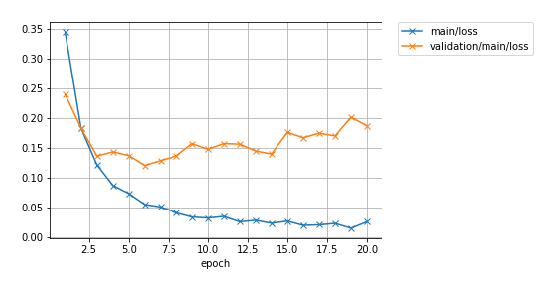

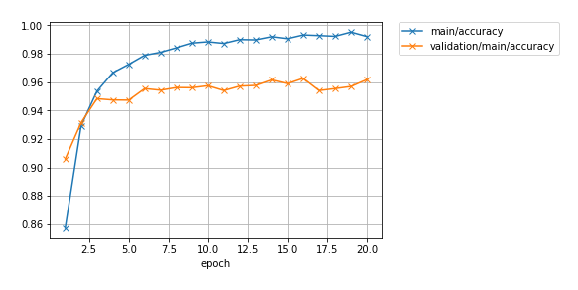

In [68]:
show_graph('result/loss.png')
show_graph('result/accuracy.png')

過学習気味

In [69]:
def predict(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred =  model.predictor(X[None, ...]).data.argmax()
    # データ数が2以上の場合はそのまま
    else:  
        pred =  model.predictor(X).data.argmax(axis=1)
    return pred

In [70]:
log_loss(y_chain_test, predict(model, X_chain_test))

1.3211227897584354

In [71]:
from sklearn.metrics import accuracy_score

In [72]:
accuracy_score(y_chain_test, predict(model, X_chain_test))

0.96175

In [73]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [74]:
def predict_rate(model, X):
    # データ数が1の場合は、バッチサイズ分の次元を追加
    if len(X.shape) == 1:  
        pred =  model.predictor(X[None, ...]).data
        return softmax(pred)
    else:
        pred =  model.predictor(X).data
        for (i, p) in enumerate(pred):
            pred[i] = softmax(p)
        return pred

In [75]:
log_loss(y_chain_test, predict_rate(model, X_chain_test)[:, 1])

/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/Users/uedatomohiro/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1694: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


nan

In [76]:
predict_rate(model, X_chain_test)

array([[2.1039748e-14, 1.0000000e+00],
       [1.0000000e+00, 1.0553886e-08],
       [9.9999642e-01, 3.5616899e-06],
       ...,
       [2.0475234e-07, 9.9999976e-01],
       [9.9994719e-01, 5.2837928e-05],
       [9.9886620e-01, 1.1338206e-03]], dtype=float32)

In [77]:
log_loss(y_test, (predict_rate(model, X_chain_test)[:,1] + rfr.predict(X_rfr_test)) / 2)

0.08268347091492342

In [79]:
(predict_rate(model, X_chain_test)[:,1] + rfr.predict(X_rfr_test)) / 2

array([1.00000000e+00, 5.27694288e-09, 6.90017808e-02, ...,
       9.78499881e-01, 1.09026419e-01, 9.50669103e-02])

MLPとrandam forest regressorの平均にしよう

In [ ]:
class MLP_3(chainer.Chain):
    def __init__(self):
        super(MLP_3, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(93, 500)
            self.l2=L.Linear(500, 800)
            self.l3=L.Linear(800, 300)
            self.l4=L.Linear(300, 2)
        
    def __call__(self, X):
        h1 = F.sigmoid(self.l1(X))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        return self.l4(h3)

In [ ]:
model_3 = L.Classifier(MLP_3())
gpu = -1 

optimizer = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer.setup(model_3) 

In [ ]:
train = tuple_dataset.TupleDataset(X_chain_train, y_chain_train)
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)
updater = training.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = training.Trainer(updater, (n_epoch,'epoch'), out='result')
test = tuple_dataset.TupleDataset(X_chain_test,y_chain_test)
test_iter = iterators.SerialIterator(test, batch_size=batch_size ,shuffle=False, repeat=False)
trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy_3.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss_3.png'))
trainer.extend(extensions.ProgressBar())

In [ ]:
trainer.run()

In [ ]:
show_graph('result/loss.png')
show_graph('result/accuracy.png')

In [ ]:
log_loss(y_test, (predict_rate(model_3, X_chain_test)[:,1] + rfr.predict(X_test) + predict_rate(model, X_chain_test)[:, 1]) / 3)

In [ ]:
log_loss(y_test, (predict_rate(model_3, X_chain_test)[:,1] + rfr.predict(X_test)) / 2)

In [ ]:
log_loss(y_test, predict_rate(model_3, X_chain_test)[:,1])

## 提出

In [80]:
test_data = pd.read_csv('test.csv')

In [81]:
first_pokemon_test = pd.DataFrame(columns=pokemon.columns)
second_pokemon_test = pd.DataFrame(columns=pokemon.columns)
for d in test_data.values:
    first_pokemon_test = first_pokemon_test.append(pokemon.iloc[d[1]-1,:])
    second_pokemon_test = second_pokemon_test.append(pokemon.iloc[d[2]-1,:])

In [82]:
first_pokemon_test.columns = 'first_' + first_pokemon_test.columns
second_pokemon_test.columns = 'second_' + second_pokemon_test.columns

In [83]:
X_submit = pd.concat([test_data, first_pokemon_test.reset_index(drop=True), second_pokemon_test.reset_index(drop=True)], axis=1)

In [84]:
X_submit = X_submit.drop('first_Type 1', axis=1).drop('first_Type 2', axis=1).drop('second_Type 1', axis=1).drop('second_Type 2', axis=1)

In [85]:
X_submit['first_Legendary'] = X_submit['first_Legendary'].map({False: 0, True: 1})
X_submit['second_Legendary'] = X_submit['second_Legendary'].map({False: 0, True: 1})

In [86]:
X_rfr_submit = X_submit.drop('first_Name', axis=1).drop('second_Name', axis=1)

In [87]:
X_dnn_submit = X_submit.drop('first_Name', axis=1).drop('second_Name', axis=1).drop('First_pokemon', axis=1).drop('Second_pokemon', axis=1).drop('first_#', axis=1).drop('second_#', axis=1)

In [89]:
X_rfr_submit_std = scaler.fit_transform(X_rfr_submit)

In [90]:
rfr_submit = RandomForestRegressor(n_estimators=1000)
rfr_submit.fit(X_rfr_std, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [91]:
model_submit = L.Classifier(MLP())
optimizer_submit = chainer.optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
optimizer_submit.setup(model_submit) 

In [92]:
train = tuple_dataset.TupleDataset(X_chain, y_chain)
train_iter = iterators.SerialIterator(train, batch_size=batch_size, shuffle=True)
updater = training.StandardUpdater(train_iter, optimizer_submit, device=gpu)
trainer_submit = training.Trainer(updater, (n_epoch,'epoch'), out='result')
trainer_submit.extend(extensions.ProgressBar())

In [93]:
trainer_submit.run()

     total [..................................................]  1.25%
this epoch [############......................................] 25.00%
       100 iter, 0 epoch / 20 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  2.50%
this epoch [#########################.........................] 50.00%
       200 iter, 0 epoch / 20 epochs
    73.545 iters/sec. Estimated time to finish: 0:01:46.057044.
     total [#.................................................]  3.75%
this epoch [#####################################.............] 75.00%
       300 iter, 0 epoch / 20 epochs
    80.325 iters/sec. Estimated time to finish: 0:01:35.860062.
     total [##................................................]  5.00%
this epoch [..................................................]  0.00%
       400 iter, 1 epoch / 20 epochs
    82.613 iters/sec. Estimated time to finish: 0:01:31.995035.
     total [###....................

     total [#####################.............................] 42.50%
this epoch [#########################.........................] 50.00%
      3400 iter, 8 epoch / 20 epochs
    65.752 iters/sec. Estimated time to finish: 0:01:09.960132.
     total [#####################.............................] 43.75%
this epoch [#####################################.............] 75.00%
      3500 iter, 8 epoch / 20 epochs
     65.52 iters/sec. Estimated time to finish: 0:01:08.681460.
     total [######################............................] 45.00%
this epoch [..................................................]  0.00%
      3600 iter, 9 epoch / 20 epochs
     65.16 iters/sec. Estimated time to finish: 0:01:07.525661.
     total [#######################...........................] 46.25%
this epoch [############......................................] 25.00%
      3700 iter, 9 epoch / 20 epochs
    64.917 iters/sec. Estimated time to finish: 0:01:06.238883.
     total [################

     total [#########################################.........] 83.75%
this epoch [#####################################.............] 75.00%
      6700 iter, 16 epoch / 20 epochs
    59.618 iters/sec. Estimated time to finish: 0:00:21.805597.
     total [##########################################........] 85.00%
this epoch [..................................................]  0.00%
      6800 iter, 17 epoch / 20 epochs
    59.402 iters/sec. Estimated time to finish: 0:00:20.201347.
     total [###########################################.......] 86.25%
this epoch [############......................................] 25.00%
      6900 iter, 17 epoch / 20 epochs
    59.256 iters/sec. Estimated time to finish: 0:00:18.563496.
     total [###########################################.......] 87.50%
this epoch [#########################.........................] 50.00%
      7000 iter, 17 epoch / 20 epochs
    59.094 iters/sec. Estimated time to finish: 0:00:16.922302.
     total [############

In [94]:
X_dnn_submit_std = scaler.fit_transform(X_dnn_submit)

In [95]:
X_submit_chain = X_dnn_submit_std.astype(xp.float32)

In [96]:
submit = (predict_rate(model_submit, X_submit_chain)[:,1] + rfr_submit.predict(X_rfr_submit_std)) / 2

first_pokemonが勝利する確率にする

In [97]:
submit = 1 - submit

In [98]:
submit_csv = pd.DataFrame(submit)

In [99]:
submit_csv.columns = ['probability']

In [100]:
submit_csv.to_csv('submit_ueda_0525.csv')

In [101]:
for (i, e) in enumerate(predict(model, X_chain) == y_chain):
    if not(e):
        print(i)
        print(predict_rate(model, X_chain[i]))

100
[[0.8320234  0.16797657]]
123
[[1.4405724e-04 9.9985588e-01]]
292
[[0.63421506 0.36578494]]
352
[[0.25221455 0.74778545]]
424
[[0.18026875 0.81973124]]
427
[[0.92088735 0.07911267]]
457
[[0.8821871  0.11781287]]
501
[[0.08595704 0.91404295]]
521
[[0.0035829  0.99641705]]
583
[[0.9777895  0.02221051]]
795
[[0.990725   0.00927507]]
811
[[0.00767199 0.992328  ]]
821
[[0.83555144 0.16444853]]
829
[[0.9150368  0.08496319]]
838
[[0.12457603 0.8754239 ]]
845
[[0.9947319  0.00526814]]
1026
[[0.7467933  0.25320664]]
1080
[[9.9954921e-01 4.5082456e-04]]
1084
[[0.3001548 0.6998452]]
1091
[[0.8487323 0.1512677]]
1188
[[0.5488583  0.45114177]]
1245
[[0.6549954 0.3450046]]
1341
[[0.00873865 0.99126136]]
1393
[[0.00143698 0.998563  ]]
1467
[[0.9973117  0.00268826]]
1540
[[0.5096355  0.49036443]]
1659
[[0.07773668 0.92226326]]
1691
[[0.8821703  0.11782963]]
1740
[[0.28032747 0.7196725 ]]
1760
[[0.292916 0.707084]]
1797
[[9.9980181e-01 1.9825225e-04]]
1844
[[0.6780028  0.32199728]]
1850
[[0.4780845

[[0.02225077 0.97774917]]
25391
[[0.94273216 0.0572678 ]]
25553
[[0.11268568 0.88731426]]
25562
[[0.7307659  0.26923406]]
25600
[[0.6800357  0.31996423]]
25672
[[0.9828098 0.0171902]]
25859
[[0.9225544  0.07744557]]
25877
[[0.24586324 0.7541367 ]]
25900
[[0.07901107 0.920989  ]]
25914
[[9.9989164e-01 1.0839693e-04]]
26063
[[0.26613536 0.73386467]]
26065
[[1.1755759e-08 1.0000000e+00]]
26215
[[0.91666365 0.08333638]]
26355
[[0.3281983  0.67180175]]
26731
[[2.0683813e-06 9.9999797e-01]]
26935
[[0.27378023 0.7262198 ]]
26988
[[0.33105078 0.66894925]]
27029
[[0.004608   0.99539196]]
27045
[[9.9991453e-01 8.5517095e-05]]
27111
[[0.00884548 0.99115455]]
27164
[[0.74195445 0.25804558]]
27179
[[9.9962342e-01 3.7657865e-04]]
27219
[[0.02340371 0.97659636]]
27223
[[0.72425395 0.27574605]]
27249
[[0.95433486 0.04566521]]
27382
[[0.29791638 0.7020836 ]]
27505
[[0.9941638  0.00583624]]
27583
[[0.98859894 0.01140106]]
27916
[[0.4561974 0.5438026]]
27945
[[0.841742   0.15825799]]
28175
[[0.99758077 0

In [6]:
import pickle

In [362]:
with open('model_2.pickle','wb') as f:
    pickle.dump(model_2, f) # (Pythonオブジェクト, pickleファイル)

with open('rfr.pickle','wb') as f:
    pickle.dump(rfr, f) # (Pythonオブジェクト, pickleファイル)

    # Pythonオブジェクトをpickleファイルとして保存
with open('first_pokemon.pickle','wb') as f:
    pickle.dump(first_pokemon, f) # (Pythonオブジェクト, pickleファイル)

with open('second_pokemon.pickle','wb') as f:
    pickle.dump(second_pokemon, f) # (Pythonオブジェクト, pickleファイル)

with open('first_pokemon_test.pickle','wb') as f:
    pickle.dump(first_pokemon_test, f) # (Pythonオブジェクト, pickleファイル)

with open('second_pokemon_test.pickle','wb') as f:
    pickle.dump(second_pokemon_test, f) # (Pythonオブジェクト, pickleファイル)

with open('model_submit.pickle','wb') as f:
    pickle.dump(model_submit, f) # (Pythonオブジェクト, pickleファイル)

with open('rfr_submit.pickle','wb') as f:
    pickle.dump(rfr_submit, f) # (Pythonオブジェクト, pickleファイル)
    
with open('model.pickle','wb') as f:
    pickle.dump(model, f)

In [2]:
# pickleファイルをPythonオブジェクトとして読込
def unpickle(file):
    with open(file,'rb') as f:
        return pickle.load(f)

# 改善点

1. firstとsecondの差を説明変数にとる
2. いらないカラムを削除する
3. 他のモデル
4. もうちょい可視化、分析（random forestとか）
5. 外したデータの観察

In [202]:
predict =  (predict_rate(model, X_chain_test)[:,1] + rfr.predict(X_test)) / 2

In [222]:
X_e = np.ndarray((32000, 2))
X_e[:,0] = predict_rate(model, X_chain_train)[:,1]
X_e[:,1] = rfr.predict(X_train)

In [229]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [230]:
lr.fit(X_e, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [231]:
X_e_test = np.ndarray((8000, 2))
X_e_test[:,0] = predict_rate(model, X_chain_test)[:,1]
X_e_test[:,1] = rfr.predict(X_test)

In [236]:
log_loss(y_test, lr.predict(X_e_test))

0.1093909979806892

In [233]:
lr.coef_

array([0.75090094, 0.26283461])

In [235]:
lr.intercept_ = 0

In [194]:
predict_sparse = predict.round()

In [196]:
predict_sparse

array([1., 0., 0., ..., 1., 0., 0.])

In [363]:
for (t, ps, p, i) in zip(y_test, predict_sparse, predict, np.arange(len(y_test))):
        if t != ps:
            print(i, t, p)

52 0 0.5565467935800552
165 0 0.7716236779689789
186 1 0.2569789982289076
215 0 0.5184710302352905
239 0 0.6241866161823273
268 1 0.4824779502227902
306 0 0.6252160158157348
314 0 0.6012782297134399
364 0 0.5066591491699218
476 0 0.7841459505558014
522 0 0.5438697774410248
534 0 0.5784039392471314
580 1 0.07407777173595968
600 0 0.5535347776412964
616 0 0.5292147038578987
641 0 0.5810580089092254
724 1 0.1465967808738351
741 0 0.561118320941925
929 1 0.4071026255786419
950 0 0.8824936819076539
1045 1 0.26578059612214566
1067 0 0.793157613992691
1086 0 0.5893545436859131
1145 1 0.15258930289914133
1253 0 0.5012557466030121
1278 0 0.5947012615203857
1355 0 0.6483114457130432
1382 1 0.12630522865056992
1415 0 0.7987308552265167
1424 0 0.5978875887393952
1518 0 0.6672280209064483
1618 0 0.8764998807907105
1690 1 0.4913323614601977
1695 0 0.6597537336349487
1817 0 0.9844999999999999
1886 0 0.672836462020874
1952 0 0.5522285902500152
1977 0 0.575486524105072
1978 1 0.2368626357356552
1984 0 

In [198]:
X_chain_test[7960]

array([ 1.0644752 , -1.3621215 , -1.5578007 , -1.3621215 ,  1.0230147 ,
       -0.12619166,  1.1273028 ,  0.8252573 ,  0.28353605, -1.3048214 ,
       -1.4004519 , -0.2994674 , -0.30985564, -0.19902037, -0.20178725,
       -0.23651285, -0.14520818, -0.18523861, -0.26398924, -0.06853436,
       -0.2035254 , -0.30620715, -0.1995628 , -0.17714325, -0.3701045 ,
       -0.19135974, -0.28464478, -0.24966447, -0.19185056,  2.4846733 ,
       -0.06357095, -0.16086568, -0.15529963, -0.08937733, -0.17104566,
       -0.18444303, -0.12267065, -0.37293684, -0.12982434, -0.17571197,
       -0.21548916, -0.13384809, -0.06944891, -0.21061613,  4.8378844 ,
       -0.1343311 , -0.16705596, -0.13776238, -1.5578007 ,  0.15943062,
       -0.08975249,  0.02933981,  0.2568273 ,  1.0070797 ,  1.0919285 ,
       -1.4128258 , -0.2988226 , -0.3086912 , -0.20252416, -0.2003066 ,
       -0.2386854 , -0.1498086 , -0.18422554,  3.7580411 , -0.06704562,
       -0.19854471, -0.30316937, -0.20044158, -0.17915986, -0.37

In [190]:
for (i, p) in enumerate(predict):
    if p > 0.75:
        predict[i] = 1
    if p < 0.25:
        predict[i] = 0

In [243]:
log_loss(y_test, predict)

0.07934609314876659

In [248]:
a = [0.5, 0.5]
log_loss(y_test, predict_rate(model, X_chain_test)[:,1] * a[0] + rfr.predict(X_test) * a[1])

0.07934609314876659

In [251]:
for i,p in enumerate(predict):
    if p > 0.99:
        predict[i] = 0.99
    if p < 0.01:
        predict[i] = 0.01

In [252]:
log_loss(y_test, predict)

0.08407032163673708

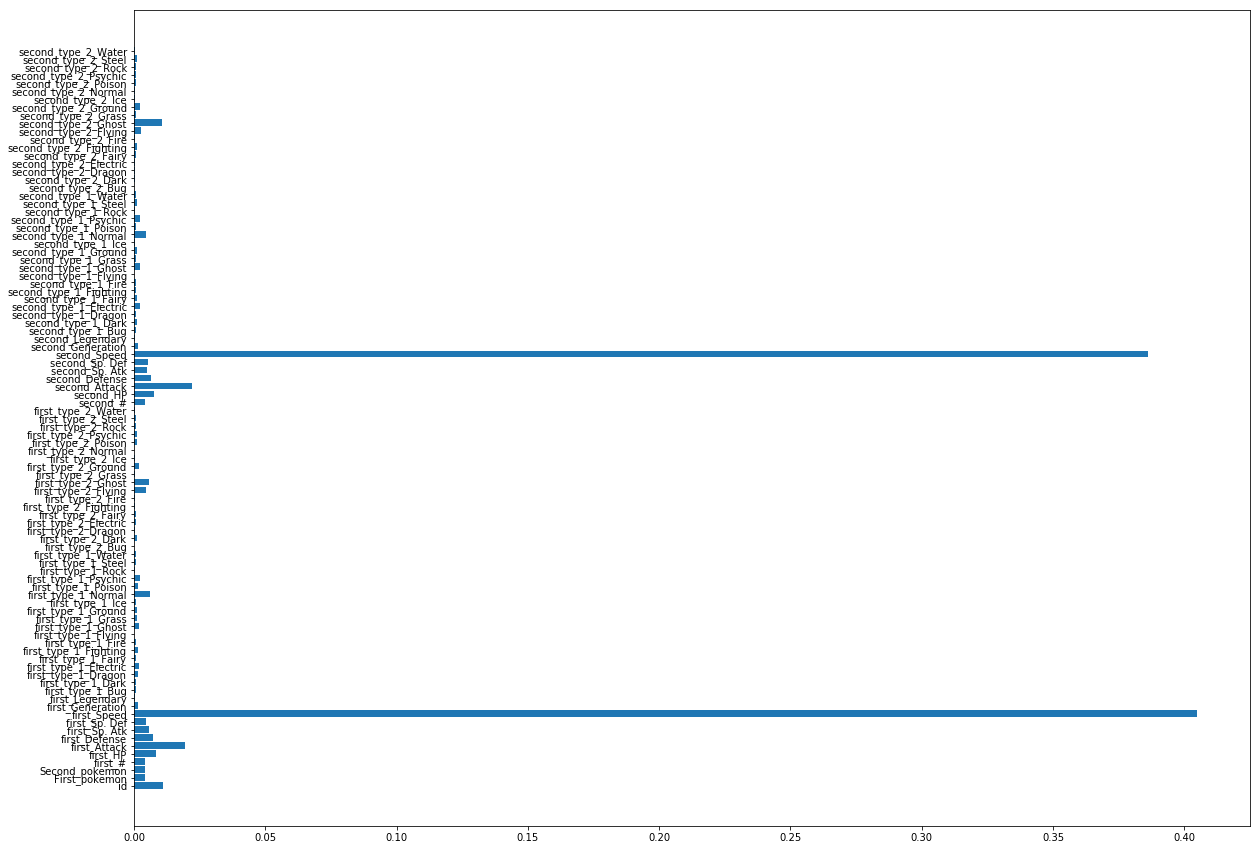

In [266]:
n_features = len(X.columns)
plt.figure(figsize=(20, 15))
plt.barh(range(n_features), rfr.feature_importances_ , align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.show()

#とidが重要視されている=>除く